In [17]:
# IMPORTING LIBRARIES AND DEFINE IMPORT FUNCTION

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy import signal
import scipy
from scipy.optimize import curve_fit
import scipy.interpolate as interp
import plotly.graph_objects as go


def importWAV(filename):
    samplerate, rawData = wavfile.read(filename)
    
    time = np.linspace(0, rawData.shape[0]/samplerate, rawData.shape[0])   
    
    data = {'left':rawData[:, 0],'right':rawData[:, 1]}
    return time,data

In [18]:
# Amplifier Code

# Resistor values (Ohm)
R_1 = 100
R_2 = 20E3
R_3 = 47E3
R_4 = 200
R_5 = 2E3

# Capacitor values (F)
C_1 = 680E-12
C_2 = 0.22E-6
C_3 = 1E-9

def Z_c(C, f):
    """
    Capacitor impedance
    """
    
    return 1 / (2 * np.pi * f * C * complex(0, 1))


def VDG(Z_1, Z_2):
    """
    Gain factor for voltage divider Op-amp circuit
    """

    return (Z_1 + Z_2) / Z_1


def VDF(Z_1, Z_2):
    """
    Voltage divider circuit gain factor
    """

    return Z_1 / (Z_2 + Z_1)


def c_amp(f):
    """
    Final complex amplification factor for entire circuit
    """
    
    return VDG(R_1, 1/(1/R_2 + 1/Z_c(C_1, f))) * VDF(R_3, Z_c(C_2, f)) * VDG(R_4, 1/(1/R_5 + 1/Z_c(C_3, f)))


def amplification(c_amp):
    """
    Converts complex amplification factor to real amplification factor
    """
    
    return np.sqrt(c_amp * c_amp.conjugate())

def phase(c_amp):
    """
    Converts complex amplification factor to phase shift
    """

    # c_amp lies in Q1 of complex plane
    if c_amp.real >= 0 and c_amp.imag >= 0:
        return np.arctan(c_amp.imag / c_amp.real)
    
    # c_amp lies in Q2 of complex plane
    elif c_amp.real < 0 and c_amp.imag >= 0:
        return -np.pi + np.arctan(c_amp.imag / c_amp.real)
   
    # c_amp lies in Q3 of complex plane
    elif c_amp.real < 0 and c_amp.imag < 0:
        return np.arctan(c_amp.imag / c_amp.real) - np.pi

    # c_amp lies in Q4 of complex plane
    else:
        return np.arctan(c_amp.imag / c_amp.real)

V_1 = 50E-3
u_V_in = 1E-3
cR_1 = 120.26E3
cf_arr = np.array([])

for i in range(21):
    f = 10 ** (i * 0.25)
    ecR_2 = cR_1 / (amplification(c_amp(f)) / 2 - 1)
    cf_arr = np.append(cf_arr, round(f))

def v_into_amp(V_in, R_1, R_2):
    return V_in * R_2 / (R_1 + R_2)


cR_2 = np.array([982.4, 982.4, 391.017, 391.017, 200.64, 150.241, 150.241, 120.543, 120.543,
                 120.543, 120.543, 120.543, 120.543, 120.543, 120.543, 120.543, 120.543,
                 120.543, 325.049, 392.225, 980.54])
obs_V_out = np.array([0.0512/2, 0.117/2, 0.0888/2, 0.227/2, 0.188/2, 0.206/2, 0.249/2, 0.217/2, 
                      0.228/2, 0.224/2, 0.223/2, 0.22/2, 0.22/2, 0.218/2, 0.211/2, 0.191/2,
                      0.153/2, 0.101/2, 0.158/2, 0.091/2, 0.0925/2])

V_in = v_into_amp(V_1, cR_1, cR_2)

G = obs_V_out / V_in

def fourier_series(x, a0, an, bn, T):
    series = a0  # Start with the constant term
    for n in range(1, len(an) + 1):
        series += an[n - 1] * np.cos(2 * np.pi * n * np.log10(x) / T) + bn[n - 1] * np.sin(2 * np.pi * n * np.log10(x) / T)
    return series

T = 5

fourier_coeffs = np.fft.fft(G) / len(cf_arr)

a0 = fourier_coeffs[0].real
an = 2 * fourier_coeffs[1:len(fourier_coeffs) // 2].real
bn = -2 * fourier_coeffs[1:len(fourier_coeffs) // 2].imag

def mod_fourier_series(x, a, b, c, d, e, f, g, h, j):
    return fourier_series(x, a0, an, bn, T) + a + b*(x+c) + d*(x+e)**2 + f*(x+g)**3 + h*(x+j)**4


params, cov = curve_fit(mod_fourier_series, cf_arr, G)

def piece_func(x):
    y = np.array([])
    
    for i in x:
        if i < 10:
            y = np.append(y, fourier_series(i, a0, an, bn, T) - 11)
        elif i < 56:
            y = np.append(y, mod_fourier_series(i, *params))
        elif i < 70:
            y = np.append(y, mod_fourier_series(i, *params) * 2.3 - 2840)
        elif i < 1000:
            y = np.append(y, fourier_series(i, a0, an, bn, T))
        elif i < 2500:
            y = np.append(y, amplification(c_amp(i)))
        elif i < 4000:
            y = np.append(y, amplification(c_amp(i)) * 1.2 - 440)
        elif i < 20000:
            y = np.append(y, mod_fourier_series(i, *params) + 10) 
        else:
            y = np.append(y, amplification(c_amp(i))*0.9 - 30)
    return y

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\1162950109.py:14: WavFileWarning:

Chunk (non-data) not understood, skipping it.



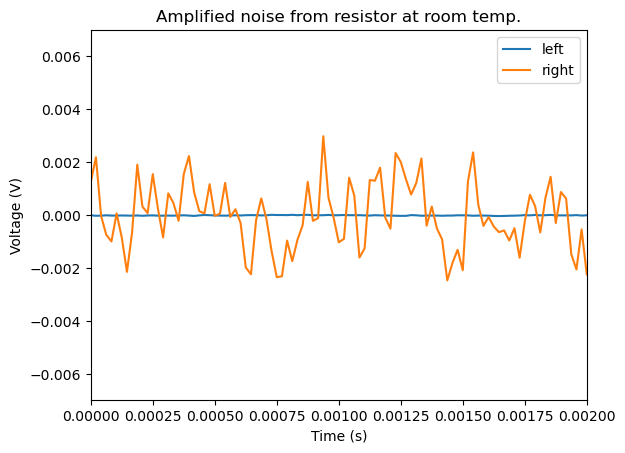

In [19]:
time,data = importWAV('1k_Ohm.wav')

v_data = {'left': [], 'right': []}

v_data['left'] = data['left'] / 8.695
v_data['right'] = data['right'] / 8.695

plt.figure()
plt.plot(time, v_data['left'], label='left')
plt.plot(time, v_data['right'], label='right')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim(0,0.002)
plt.title('Amplified noise from resistor at room temp.')

plt.legend()

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\1477105198.py:103: RuntimeWarning:

divide by zero encountered in log10

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\1477105198.py:103: RuntimeWarning:

invalid value encountered in cos

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\1477105198.py:103: RuntimeWarning:

invalid value encountered in sin

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\511085552.py:10: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\511085552.py:11: RuntimeWarning:

invalid value encountered in true_divide



Average noise power density over the stated range is (3.33605294671761e-17+0j)
513


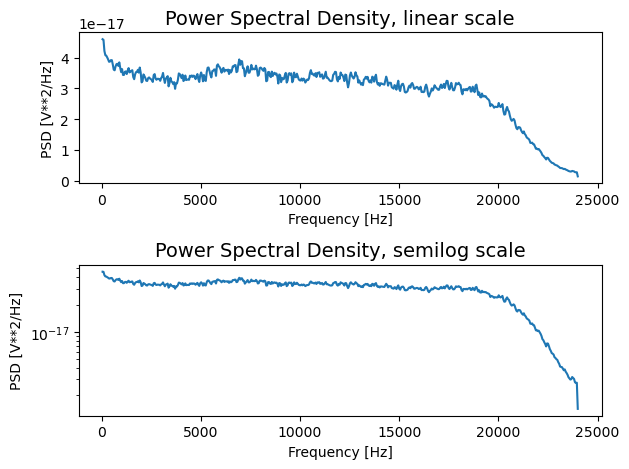

In [20]:
# Periodogram and Welch are two techniques for calculating power spectra, with advantages and disadvantages.
# It is easy to calculate an averaged power spectrum using Welch

fs = 48000

#f, Pxx_den = signal.periodogram(v_data['right'], fs, 'flattop', scaling='density')
rf, rPxx_den = signal.welch(v_data['right'], fs, nperseg=1024)
lf, lPxx_den = signal.welch(v_data['left'], fs, nperseg=1024)

rPxx_den = rPxx_den / piece_func(rf) ** 2
lPxx_den = lPxx_den / piece_func(lf) ** 2

# maxloc = np.argmax(Pxx_den)
# print("Max is at point number",maxloc)

# rng=20
# peaksum = sum(Pxx_den[(maxloc-rng):(maxloc+rng)])
# print("Sum of PSD within rng points of peak is",peaksum)

# binsize = f[1]-f[0]
# print("Bin size is",binsize)

# sinepower = peaksum*binsize
# print("Total power with rng points of peak is",sinepower)

noisepowerden = np.average(rPxx_den[5:400]) # Make sure this does not include elements beyond the length of Pxx_den
print("Average noise power density over the stated range is", noisepowerden)
print(len(rPxx_den))

fig1, (ax1, ax2) = plt.subplots(2)

ax1.set_xlabel('Frequency [Hz]', fontsize=10)
ax1.set_ylabel('PSD [V**2/Hz]', fontsize=10)
ax1.set_title('Power Spectral Density, linear scale', fontsize=14)
ax2.set_xlabel('Frequency [Hz]', fontsize=10)
ax2.set_ylabel('PSD [V**2/Hz]', fontsize=10)
ax2.set_title('Power Spectral Density, semilog scale', fontsize=14)
ax1.plot(rf, rPxx_den)
ax2.semilogy(rf, rPxx_den)
fig1.tight_layout()

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\1162950109.py:14: WavFileWarning:

Chunk (non-data) not understood, skipping it.

C:\Users\logan\AppData\Local\Temp\ipykernel_1732\2167839980.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

c:\Users\logan\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning:

Casting complex values to real discards the imaginary part



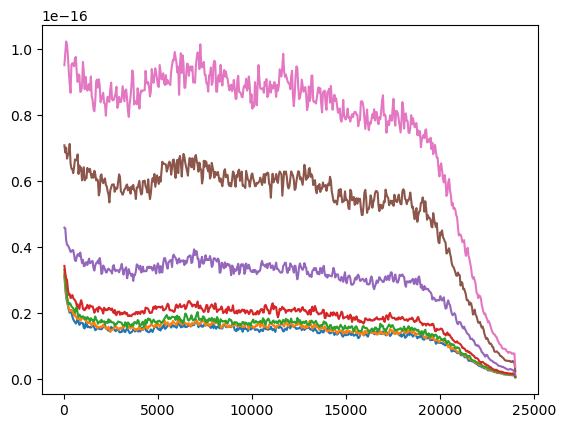

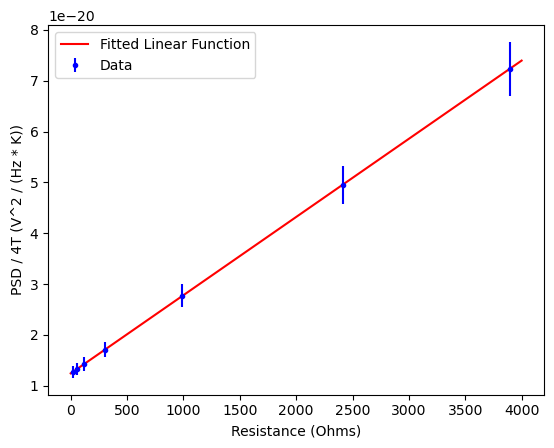

ValueError: 
    Invalid value of type 'builtins.str' received for the 'fill' property of scatter
        Received value: 'blue'

    The 'fill' property is an enumeration that may be specified as:
      - One of the following enumeration values:
            ['none', 'tozeroy', 'tozerox', 'tonexty', 'tonextx',
            'toself', 'tonext']

In [25]:
R_18 = 17.962
R_56 = 56.217
R_120 = 120.538
R_300 = 302.203
R_1k = 990.65
R_2k = 2411.65
R_3_9k = 3895.67

Temp = 298.15
Temp_std = 1.5

fs = 48000

G_red_chi_sq = 1.3595060880706404

Pden_arr = np.array([])
Pden_std_arr = np.array([])
R_arr = np.array([R_18, R_56, R_120, R_300, R_1k, R_2k, R_3_9k])

time18, data18 = importWAV('18_Ohm.wav')
time56, data56 = importWAV('56_Ohm.wav')
time120, data120 = importWAV('120_Ohm.wav')
time300, data300 = importWAV('300_Ohm.wav')
time1k, data1k = importWAV('1k_Ohm.wav')
time2k, data2k = importWAV('2k_Ohm.wav')
time3_9k, data3_9k = importWAV('3_9k_Ohm.wav')

SC_cal = 8.695

v_data18 = data18['right'] / SC_cal
v_data56 = data56['right'] / SC_cal
v_data120 = data120['right'] / SC_cal
v_data300 = data300['right'] / SC_cal
v_data1k = data1k['right'] / SC_cal
v_data2k = data2k['right'] / SC_cal
v_data3_9k = data3_9k['right'] / SC_cal

v_data_arr = np.array([v_data18, v_data56, v_data120, v_data300, v_data1k, v_data2k, v_data3_9k])

for v_dat in v_data_arr:
    f, Pxx_den = signal.welch(v_dat, fs, nperseg=1024)
    f = f[1:]
    Pxx_den = Pxx_den[1:]
    Pxx_den = Pxx_den / piece_func(f) ** 2
    flat_Pxx_den = Pxx_den[5:420]
    plt.plot(f, Pxx_den, scalex='log')

    data_std = np.sqrt(np.sum((2 * flat_Pxx_den * np.sqrt((3 / 40) ** 2
                      + G_red_chi_sq * (5.66 / 100) ** 2)) ** 2)).real / len(flat_Pxx_den)
    Pden_std_arr = np.append(Pden_std_arr, np.sqrt(np.std(flat_Pxx_den) ** 2 + data_std ** 2))
    Pden_arr = np.append(Pden_arr, np.mean(flat_Pxx_den).real)

def lin_func(x, a, b):
    return a*x + b

def quad_func(x, a, b, c):
    return a*x**2 + b*x + c

kb_slope_arr = Pden_arr / (4 * Temp)
kb_slope_std_arr = Pden_arr / (4 * Temp) * np.sqrt((Pden_std_arr / Pden_arr) ** 2 + (Temp_std / Temp) ** 2)

params_lin, cov_lin = curve_fit(lin_func, R_arr, kb_slope_arr, sigma=kb_slope_std_arr)
p_lin_err = np.sqrt(np.diag(cov_lin))

params_quad, cov_quad = curve_fit(quad_func, R_arr, kb_slope_arr, sigma=kb_slope_std_arr)
p_quad_err = np.sqrt(np.diag(cov_quad))

R_space = np.linspace(0, 4000, 1000)

plt.figure(0)
plt.errorbar(R_arr, kb_slope_arr, kb_slope_std_arr, fmt='b.', label='Data')
plt.plot(R_space, lin_func(R_space, *params_lin), 'r', label='Fitted Linear Function')
#plt.plot(R_space, quad_func(R_space, *params_quad), label='Fitted Quadratic Function')
plt.xlabel('Resistance (Ohms)')
plt.ylabel('PSD / 4T (V^2 / (Hz * K))')
plt.legend()
plt.show()

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=R_arr, y=kb_slope_arr,
    error_y=dict(
        type='data',
        array=kb_slope_std_arr
        color='blue'
    ),
    name='Data', 
    mode='markers',
))

fig.show()

print('Lin param: {} +/- {} , Const param: {} +/- {}'.format(params_lin[0], p_lin_err[0], params_lin[1], p_lin_err[1]))
print('Quad param: {} +/- {} , Lin param: {} +/- {} , Const param: {} +/- {}'.format(params_quad[0], p_quad_err[0], params_quad[1],
                                                                                     p_quad_err[1], params_quad[2], p_quad_err[2]))